In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="64GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.120.147/366631/1' processes=1 threads=256, memory=59.60 GiB>

In [3]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'dpp0066'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip/daily/')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066 = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [4]:
file_imerg2020 = '/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG/IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_2020.nc'

In [5]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [6]:
def time_mean_model(file,times,lat,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4')
        pr=dset1.pr.sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim='time')
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1.pr.where(lsmask01<0).sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim='time',skipna=True)
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1.pr.where(lsmask01>0).sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim=('time'),skipna=True)
    
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

In [7]:
def time_mean_imerg(file,times,lat,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4')
        pr=dset1['calibrated_precipitation'].sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim='time')
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1['calibrated_precipitation'].where(lsmask01<0).sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim='time',skipna=True)
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1['calibrated_precipitation'].where(lsmask01>0).sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim=('time'),skipna=True)
    else:
        print('I do not understand')
        
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

In [8]:
def time_clim_imerg(file,times,lat,environ):
    if environ is 'trop':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4')
        pr=dset1['calibrated_precipitation'].sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim='time',skipna=True)
    elif environ is 'ocean':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1['calibrated_precipitation'].where(lsmask01<0).sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim='time',skipna=True)
    elif environ is 'land':
        dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4')
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        pr=dset1['calibrated_precipitation'].where(lsmask01>0).sel(time=slice(times[0],times[1]),lat=slice(lat[0],lat[1])).mean(dim=('time'),skipna=True)
    else:
        print('I do not understand')
        
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

_Calculate clim mean for certain period_

In [9]:
def annual_mean_sel(dset,years,dates):
    pr = dset.sel(time=slice(str(years)+dates[0],str(years)+dates[1])).groupby("time.year").mean(dim='time')
    return pr

In [10]:
def time_mean_imerg_multi(file,dates,lon,lat):
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4')['calibrated_precipitation']
    pr=dset1.sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))

    years = np.unique(pr['time.year'])
    annual_mean = np.zeros((years.size,pr.shape[1],pr.shape[2]))
    for t in range(years.size):
        pr1 = annual_mean_sel(pr,years[t],dates)
        jobs = dask.persist(pr1)
        progress(jobs, notebook=False)
        precip = dask.compute(pr1)
        if t == 0:
            precipf = precip[0]
        else:
            precipf = xr.concat([precipf,precip[0]],dim='year')    
        precip_mean = precipf.mean(dim=('year'),skipna=True) 
    return precip_mean

## Calculate the annual mean in ICON and IMERG

**ICON-S**

In [1]:
%time dpp66_mean_trop = time_mean_model(file_dpp0066,['2020-02-01','2021-01-31'],[-30,30],'trop')

NameError: name 'time_mean_model' is not defined

**Climatology of IMERG**

In [13]:
%time imerg_mean_trop_all = time_clim_imerg(file_imerg,['2001-02-01','2021-01-31'],[-30,30],'trop')

CPU times: user 1min 7s, sys: 1min 35s, total: 2min 42s
Wall time: 1min 17s


**Plotting maps**

In [65]:
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

_Adding new color bar_

In [21]:
GnBu = cm.get_cmap('GnBu', 128)
newcolors = GnBu(np.linspace(0, 1, 128))
white = np.array([1, 1, 1, 1])
newcolors[0:12, :] = white
blue = np.array([0.11, 0.11, 0.5, 1])
newcolors[120:124, :] = blue
black = np.array([0, 0, 0, 1])
newcolors[124:128, :] = black
GnBu_mod = ListedColormap(newcolors)

In [22]:
GnBu2 = cm.get_cmap('YlGnBu', 12)
newcolors2 = GnBu2(np.linspace(0, 1, 12))
white = np.array([1, 1, 1, 1])
scnd = np.array([0.89051745, 0.76469402, 0.71028506 , 1])
newcolors2[0, :] = white
newcolors2[1, :] = scnd
clevs = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25,
         30, 35]
GnBu_mod2 = ListedColormap(newcolors2,'precip')
GnBu_mod2_norm = BoundaryNorm(clevs,GnBu_mod2.N)

In [23]:
def subplot_precip(ax,data,ranges,cmap,colorbar,ax_cbar,extends,title):
    plot = (data).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels = np.linspace(ranges[0],ranges[1],ranges[2]),
    extend='both', add_colorbar=False)

    ax.set_title(title,fontsize=16)   
    ax.coastlines(resolution='110m',linewidth=0.6)
    ax.set_extent([-180, 179.9, -30, 30], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-30,31,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(np.arange(-180,179,60),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    if colorbar == True: 
        cb1 = plt.colorbar(plot,extend=extends,orientation='horizontal',cax=ax_cbar,shrink=0.8,pad=0.09)
        cb1.ax.set_xlabel('Precipitation / mm day$^{-1}$',fontsize=12)
        cb1.ax.tick_params(labelsize=12)
    return cb1

In [63]:
def subplot_precip2(ax,data,clevs,cmap,norm,colorbar,ax_cbar,extends,title):
    plot = (data).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels = clevs,
    cmap=cmap,
    norm = norm,
    
    extend=extends, add_colorbar=False)

    ax.set_title(title,fontsize=16)   
    ax.coastlines(resolution='110m',linewidth=0.6)
    ax.set_extent([-180, 179.9, -30, 30], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-30,31,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(np.arange(-180,179,60),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    if colorbar == True: 
        cb1 = plt.colorbar(plot,extend=extends,orientation='horizontal',cax=ax_cbar,shrink=0.8,pad=0.09)
        cb1.ax.set_xlabel('Precipitation / mm day$^{-1}$',fontsize=12)
        cb1.ax.tick_params(labelsize=12)
    return cb1

In [66]:
def subplot_contour(ax,data,levels,cmap,linestyles,transform):
    plot = (data).plot.contour(
    ax=ax,
    transform=transform,
    colors=cmap,
    levels = levels,
    linestyles = linestyles)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

In [67]:
from scipy.ndimage.filters import gaussian_filter

## Figure 1A

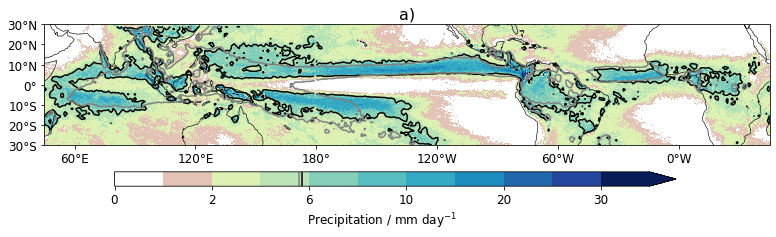

In [32]:
fig = plt.figure(figsize=(13, 4))
ax1=fig.add_axes([0.2,0.15,0.6,0.05])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cbar1 = subplot_precip2(ax,(dpp66_mean_trop*24*3600),GnBu_mod2,True,ax1,'max',f'a)')
subplot_contour(ax,dpp66_mean_trop[::12,::12],levels=[dpp66_mean_trop.quantile(0.8)],cmap='black',linestyles='-',transform=ccrs.PlateCarree())
subplot_contour(ax,imerg_mean_trop_all[::8,::8],levels=[imerg_mean_trop_all.quantile(0.8)],cmap='gray',linestyles='-',transform=ccrs.PlateCarree())
ax.set_title('a)',fontsize=16)
cbar1.ax.plot([dpp66_mean_trop.quantile(0.8)*24*3600, dpp66_mean_trop.quantile(0.8)*24*3600], [0,1], 'k') 
cbar1.ax.plot([imerg_mean_trop_all.quantile(0.8), imerg_mean_trop_all.quantile(0.8)], [0,1], 'gray') 
plt.savefig('/scratch/m/m300876/results/precip_paper/clim_precp_dpp0066_imerg_q80_2020_02_2021_01.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


## Calculate the austral-boreal summer difference of precipitation. 

**ICON-S**

In [14]:
dpp66_mean_trop_jf = time_mean_model(file_dpp0066,['2021-01-01','2021-03-01'],[-30,30],'trop')

In [15]:
dpp66_mean_trop_as = time_mean_model(file_dpp0066,['2020-08-01','2020-10-01'],[-30,30],'trop')

**Climatology of IMERG**

In [18]:
imerg_mult_jf = time_mean_imerg_multi(file_imerg,['-01-01','-03-01'],[-180,180],[-30,30])

In [19]:
imerg_mult_as = time_mean_imerg_multi(file_imerg[:-2],['-08-01','-09-30'],[-180,180],[-30,30])

**Smoothing IMERG data for contouring**

In [ ]:
from scipy.ndimage.filters import gaussian_filter

In [34]:
season_dif_imerg = imerg_mult_jf-imerg_mult_as

In [35]:
raw_data = season_dif_imerg

In [36]:
filter_data = gaussian_filter(raw_data, 4)

## Figure 1B

**Plot seasonal precipitation difference**

In [73]:
BrBG2 = cm.get_cmap('BrBG', 14)
newcolors2 = BrBG2(np.linspace(0, 1, 14))
white = np.array([1, 1, 1, 1])
#scnd = np.array([0.89051745, 0.76469402, 0.71028506 , 1])
newcolors2[6, :] = white
newcolors2[7, :] = white
newcolors2[8, :] = white
clevs = [-30, -20, -15, -10, -6, -3, 0, 3, 6, 10,
         15, 20, 30]
BrBG2 = ListedColormap(newcolors2,'precip')
BrBG2_norm = BoundaryNorm(clevs,BrBG2.N)

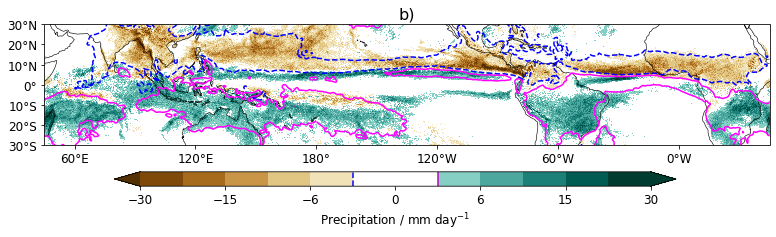

In [77]:
fig = plt.figure(figsize=(13, 4))
ax1=fig.add_axes([0.2,0.15,0.6,0.05])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
cbar1 = subplot_precip2(ax,((dpp66_mean_trop_jf-dpp66_mean_trop_as)*3600*24),clevs,BrBG2,BrBG2_norm,True,ax1,'both',f'b)')
plt.contour(season_dif_imerg.lon,season_dif_imerg.lat,filter_data,levels=[-3],colors='blue',transform=ccrs.PlateCarree())
plt.contour(season_dif_imerg.lon,season_dif_imerg.lat,filter_data,levels=[3],colors='magenta',transform=ccrs.PlateCarree())
cbar1.ax.plot([-3, -3], [0,1], '--b') 
cbar1.ax.plot([3, 3], [0,1], '-m') 
plt.savefig('/scratch/m/m300876/results/precip_paper/diff_JF_minus_AS_dpp0066_imerg_3mm_2020_2021_clim_gausian.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


## Calculate interannual variability

In [13]:
def spatial_mean_model(file,var,times,environ):
    earthr = 6.371e6
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks='auto',engine='netcdf4', parallel=True)
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    if environ is 'trop':
        area_total = area.sel(lat=slice(-30,30)).sum()
        pr=((dset1[var]*area).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).sum(dim=('lon','lat'))/area_total)
    elif environ is 'ocean':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01<0).sel(lat=slice(-30,30)).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01<0).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).sum(dim=('lon','lat'),skipna=True)/area_total)
    elif environ is 'land':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01>0).sel(lat=slice(-30,30)).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01>0).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).sum(dim=('lon','lat'),skipna=True)/area_total)
    
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

In [14]:
def spatial_clim_imerg(file,var,times,environ):
    earthr = 6.371e6
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4', parallel=True)
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    if environ is 'trop':
        area_total = area.sel(lat=slice(-30,30)).sum()
        data=(dset1[var]*area).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).resample(time='A').mean()
        pr =  (data.sum(dim=('lon','lat'))/area_total)
    elif environ is 'ocean':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01<0).sel(lat=slice(-30,30)).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01<0).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).resample(time='1AS').mean().sum(dim=('lon','lat'),skipna=True)/area_total)
    elif environ is 'land':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01>0).sel(lat=slice(-30,30)).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01>0).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).resample(time='1AS').mean().sum(dim=('lon','lat'),skipna=True)/area_total)
    
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

In [40]:
def spatial_clim_imerg2(file,var,times,lat,lon,environ):
    earthr = 6.371e6
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4', parallel=True).sel(
        lat=slice(lat[0],lat[1])).sel(time=slice(times[0],times[1])).resample(time='1AS').mean()
    dset1 = dset1.where((dset1.lon>lon[0]) | (dset1.lon<lon[1]))
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    if environ is 'trop':
        area_total = area.sel(lat=slice(-30,30)).sum()
        data=(dset1[var]*area).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).resample(time='A').mean()
        pr =  (data.sum(dim=('lon','lat'))/area_total)
    elif environ is 'ocean':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where((lsmask01<0) & ((dset1.lon>lon[0]) | (dset1.lon<lon[1]))
                               ).sel(lat=slice(lat[0],lat[1])).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01<0).sum(dim=('lon','lat'),skipna=True)/area_total)
    elif environ is 'land':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01>0).sel(lat=slice(-30,30)).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01>0).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).sum(dim=('lon','lat'),skipna=True)/area_total)
    
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

In [48]:
def spatial_clim_imerg3(file,var,times,lat,lon,environ):
    earthr = 6.371e6
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4', parallel=True).sel(
        lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).sel(
        time=slice(times[0],times[1])).resample(time='1AS').mean()
    loncmorph,latcmorph = np.meshgrid(dset1.lon.values,dset1.lat.values)
    area = xr.DataArray(data = (0.1/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(0.1/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset1.lat.values),
                        lon=(["lon"],dset1.lon.values),))
    if environ is 'trop':
        area_total = area.sel(lat=slice(-30,30)).sum()
        data=(dset1[var]*area).sel(time=slice(times[0],times[1]),lat=slice(-30,30)).resample(time='A').mean()
        pr =  (data.sum(dim=('lon','lat'))/area_total)
    elif environ is 'ocean':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01<0).sel(
            lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]) ).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01<0).sum(dim=('lon','lat'),skipna=True)/area_total)
    elif environ is 'land':
        ####sea_land_mask
        filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
        dsetmask = xr.open_dataset(filemask)
        lsmask01 = dsetmask.landseamask.where(dsetmask.landseamask<100).interp(lon=dset1.lon.values,lat=dset1.lat.values,method='linear') *0 +2
        lsmask01 = lsmask01.where(lsmask01==2,-2)
        area_total = area.where(lsmask01>0).sel(
            lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).sum(skipna=True)
        pr=((dset1[var]*area).where(lsmask01>0).sum(dim=('lon','lat'),skipna=True)/area_total)
    
    jobs = dask.persist(pr)
    varf = dask.compute(pr)
    return varf[0]

In [57]:
def temp_clim_imerg2(file,var,times,lat,lon):
    earthr = 6.371e6
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4')[var].sel(
        lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).sel(
        time=slice(times[0],times[1])).resample(time='1AS').mean()
    return dset1.compute()

**ICON-S**

In [15]:
trop_dpp66 = spatial_mean_model(file_dpp0066,'pr',['2020-02-01','2021-01-31'],'trop')

In [16]:
land_dpp66 = spatial_mean_model(file_dpp0066,'pr',['2020-02-01','2021-01-31'],'land')

In [17]:
ocean_dpp66 = spatial_mean_model(file_dpp0066,'pr',['2020-02-01','2021-01-31'],'ocean')

**IMERG in 2020**

In [18]:
trop_imerg = spatial_mean_model(file_imerg,'calibrated_precipitation',['2020-01-01','2020-12-31'],'trop')

In [19]:
land_imerg = spatial_mean_model(file_imerg,'calibrated_precipitation',['2020-01-01','2020-12-31'],'land')

In [20]:
ocean_imerg = spatial_mean_model(file_imerg,'calibrated_precipitation',['2020-01-01','2020-12-31'],'ocean')

**IMERG climatology 2001-2020**

In [21]:
trop_imerg_clim = spatial_clim_imerg(file_imerg,'calibrated_precipitation',['2001-01-01','2020-12-31'],'trop')

In [22]:
land_imerg_clim = spatial_clim_imerg(file_imerg,'calibrated_precipitation',['2001-01-01','2020-12-31'],'land')

In [23]:
ocean_imerg_clim = spatial_clim_imerg(file_imerg,'calibrated_precipitation',['2001-01-01','2020-12-31'],'ocean')

## Figure S1

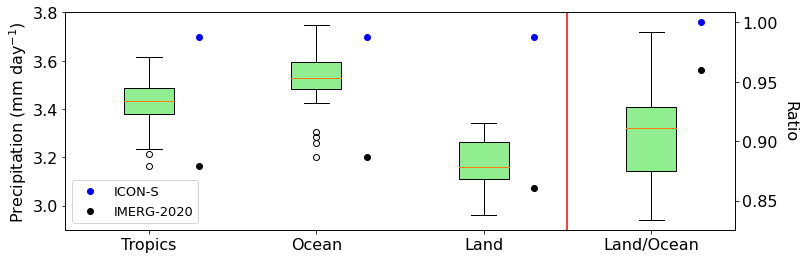

In [24]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
bplot1= plt.boxplot([trop_imerg_clim.values,ocean_imerg_clim.values,land_imerg_clim.values],patch_artist=True)
plt.plot([1.3,2.3,3.3],[trop_dpp66.mean()*3600*24,ocean_dpp66.mean()*3600*24,land_dpp66.mean()*3600*24],'ob',label='ICON-S')
plt.plot([1.3,2.3,3.3],[trop_imerg.mean(),ocean_imerg.mean(),land_imerg.mean()],'ok',label='IMERG-2020')
plt.plot([3.5,3.5],[2.8,3.8],'-r');ax.set_ylim([2.9,3.8])
ax.set_ylabel('Precipitation (mm day$^{-1}$)',fontsize=16)
ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
bplot2 = ax2.boxplot([land_imerg_clim.values/ocean_imerg_clim.values],positions=[4],widths=0.3,patch_artist=True)
ax2.plot([4.3],[land_dpp66.mean()/ocean_dpp66.mean()],'ob')
ax2.plot([4.3],[land_imerg.mean()/ocean_imerg.mean()],'ok')
ax.set_xticklabels(['Tropics','Ocean','Land','Land/Ocean'])
ax.tick_params(labelsize=16); ax2.tick_params(labelsize=16)
ax2.set_ylabel('Ratio',fontsize=16,rotation=-90,labelpad=20)


plt.setp(bplot1["boxes"], facecolor='lightgreen')
plt.setp(bplot2["boxes"], facecolor='lightgreen')
ax.legend(loc=3,fontsize=13)

plt.savefig('/scratch/m/m300876/results/precip_paper/statistics_mean_precipitation_dpp0066_imerg2.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})


**Calculate double ITCZ index according to Samanta et al. (2019)**

In [41]:
ocean_imerg_clim_eq = spatial_clim_imerg2(file_imerg,'calibrated_precipitation',['2001-01-01','2020-12-31']\
                                          ,[-5,5],[160,-120],'ocean')

In [42]:
ocean_imerg_clim_sh = spatial_clim_imerg2(file_imerg,'calibrated_precipitation',['2001-01-01','2020-12-31']\
                                          ,[-15,-5],[160,-120],'ocean')

In [43]:
ocean_imerg_clim_nh = spatial_clim_imerg2(file_imerg,'calibrated_precipitation',['2001-01-01','2020-12-31']\
                                          ,[5,15],[160,-120],'ocean')

In [93]:
((ocean_imerg_clim_nh + ocean_imerg_clim_sh)/2 - ocean_imerg_clim_eq)

<xarray.DataArray (time: 20)>
array([ 2.2206697 ,  0.66328   ,  1.788948  ,  2.326735  ,  1.6109676 ,
        2.2448754 ,  1.9609451 ,  2.4347472 ,  1.7827659 ,  0.73003125,
        2.0086634 ,  1.6642108 ,  2.9270585 ,  1.8772647 , -0.18805265,
        1.0178661 ,  2.5518835 ,  3.2356346 ,  0.99907255,  2.667849  ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2002-01-01 ... 2020-01-01